Epoch  0 : Ave objective= 1.154957784295005  Ave training loss:  0.6406195357600565
Epoch  50 : Ave objective= 0.31972884746753566  Ave training loss:  0.21697409475481894
Epoch  100 : Ave objective= 0.3169584528695154  Ave training loss:  0.2004353198945896
Epoch  150 : Ave objective= 0.3174848263166199  Ave training loss:  0.19907048192746526
Epoch  200 : Ave objective= 0.30842976514339926  Ave training loss:  0.20871549107813603
Epoch  250 : Ave objective= 0.3139134541890106  Ave training loss:  0.20123873768229558
Epoch  300 : Ave objective= 0.31489509899874984  Ave training loss:  0.19747026526366818
Epoch  350 : Ave objective= 0.31563058675307576  Ave training loss:  0.19720434085299576
Epoch  400 : Ave objective= 0.31338016031878724  Ave training loss:  0.20334435785251803
Epoch  450 : Ave objective= 0.31370357750654826  Ave training loss:  0.19724184757689917
Epoch  500 : Ave objective= 0.30992356532032284  Ave training loss:  0.19774360536643684
Epoch  550 : Ave objective= 0.3

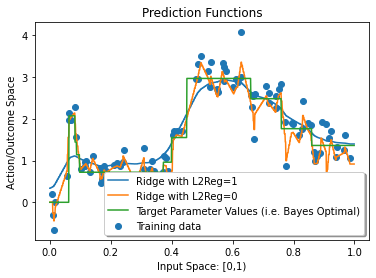

In [1]:
import setup_problem
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import nodes
import graph
import plot_utils

class RidgeRegression(BaseEstimator, RegressorMixin):
    """ Ridge regression with computation graph """
    def __init__(self, l2_reg=1, step_size=.005,  max_num_epochs = 5000):
        self.max_num_epochs = max_num_epochs
        self.step_size = step_size

        # Build computation graph
        self.x = nodes.ValueNode(node_name="x") # to hold a vector input
        self.y = nodes.ValueNode(node_name="y") # to hold a scalar response
        self.w = nodes.ValueNode(node_name="w") # to hold the parameter vector
        self.b = nodes.ValueNode(node_name="b") # to hold the bias parameter (scalar)
        self.prediction = nodes.VectorScalarAffineNode(x=self.x, w=self.w, b=self.b,
                                                 node_name="prediction")
        
        
        self.square_loss = nodes.SquaredL2DistanceNode(a=self.prediction, b=self.y, node_name="square loss")
        self.reg = nodes.L2NormPenaltyNode(l2_reg=l2_reg, w=self.w, node_name='l2 regularization')
        
        self.objective = nodes.SumNode(a = self.square_loss, b=self.reg, node_name = 'objective function')
        
        
        self.inputs = [self.x]
        self.outcomes = [self.y]
        self.parameters = [self.w, self.b]
        
        self.graph = graph.ComputationGraphFunction(self.inputs, self.outcomes,
                                                          self.parameters, self.prediction,
                                                          self.objective)
        

    def fit(self, X, y):
        num_instances, num_ftrs = X.shape
        y = y.reshape(-1)

        init_parameter_values = {"w": np.zeros(num_ftrs), "b": np.array(0.0)}
        self.graph.set_parameters(init_parameter_values)

        for epoch in range(self.max_num_epochs):
            shuffle = np.random.permutation(num_instances)
            epoch_obj_tot = 0.0
            for j in shuffle:
                obj, grads = self.graph.get_gradients(input_values = {"x": X[j]},
                                                    outcome_values = {"y": y[j]})
                epoch_obj_tot += obj
                # Take step in negative gradient direction
                steps = {}
                for param_name in grads:
                    steps[param_name] = -self.step_size * grads[param_name]
                    self.graph.increment_parameters(steps)

            if epoch % 50 == 0:
                train_loss = sum((y - self.predict(X,y)) **2)/num_instances
                print("Epoch ",epoch,": Ave objective=",epoch_obj_tot/num_instances," Ave training loss: ",train_loss)

    def predict(self, X, y=None):
        try:
            getattr(self, "graph")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        num_instances = X.shape[0]
        preds = np.zeros(num_instances)
        for j in range(num_instances):
            preds[j] = self.graph.get_prediction(input_values={"x":X[j]})

        return preds



def main():
    lasso_data_fname = "lasso_data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = setup_problem.load_problem(lasso_data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)

    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    X = featurize(x)

    l2reg = 1
    estimator = RidgeRegression(l2_reg=l2reg, step_size=0.00005, max_num_epochs=2000)
    estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name, "preds": estimator.predict(X) })


    l2reg = 0
    estimator = RidgeRegression(l2_reg=l2reg, step_size=0.0005, max_num_epochs=500)
    estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name, "preds": estimator.predict(X) })

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.

    pred_fns.append({"name": "Target Parameter Values (i.e. Bayes Optimal)", "coefs": coefs_true, "preds": target_fn(x)})

    plot_utils.plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")

if __name__ == '__main__':
    main()
